In [1]:
import sys
import os

current_directory = os.getcwd()        
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from spektral.layers import GCNConv

from postprocess.threshold import flood_threshold, drought_threshold
from preprocess.BaselinePrerocess import baseline_process, baseline_process_for_gate_predictor
from preprocess.GraphTransformerPrerocess import graph_water_transformer_cov_process_for_gate_predictor
from preprocess.graph import graph_topology_5

import pygad
import time

2023-08-05 12:56:24.211433: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-05 12:56:25.808384: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

### Preprocess

In [4]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9
sigma2 = 0.1
epsilon = 0.5

In [5]:
train_cov, val_cov, test_cov, \
train_tws_reshape, val_tws_reshape, test_tws_reshape, \
train_gate_pump_y, val_gate_pump_y, test_gate_pump_y, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler, gate_scalar = graph_water_transformer_cov_process_for_gate_predictor(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')
train_tws/val_tws/test_tws: (77069, 5, 72) (9634, 5, 72) (19268, 5, 72) 
 train_cov/val_cov/test_cov: (77069, 96, 12) (9634, 96, 12) (19268, 96, 12) 
 train_ws_y/val_ws_y/test_ws_y: (77069, 96) (9634, 96) (19268, 96) 
  train_gate_pump_y/val_gate_pump_y/test_gate_pump_y: (77069, 24, 7) (9634, 24, 7) (19268, 24, 7)


In [6]:
train_adj_mat, val_adj_mat, test_adj_mat = graph_topology_5(n_hours, K, sigma2, epsilon, len(train_ws_y), len(val_ws_y), len(test_ws_y))

node_indices: [0 0 0 0 1 1 2 2 3 3 4 4] 
neighbor_indices: [1 2 3 4 0 2 0 1 0 4 0 3]
number of nodes: 5, number of edges: 12


### Select event

In [7]:
start_idx = 13000
end_idx = 13100
duration = end_idx - start_idx

In [8]:
ws1 = test_ws_y[start_idx:end_idx, :]
ws1 = ws_scaler.inverse_transform(ws1)
ws1.shape

(100, 96)

In [9]:
# plt.plot(ws1[:, 0], label='S1')
# plt.xlabel('Time', fontsize=18)
# plt.ylabel('S1 Water Stage', fontsize=18)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.legend(fontsize=14)
# plt.show()

### Get optimizable and not optimizable variables

In [10]:
# X = test_X_mask[start_idx:end_idx, :, :]
# X_1d = np.reshape(X, -1)

# print(X.shape)
# print(X_1d.shape)

In [11]:
# optimizable
gate_state = test_cov[start_idx:end_idx, :, 2:9]
gate_state_1d = np.reshape(gate_state, -1)

print(gate_state.shape)
print(gate_state_1d.shape)

(100, 96, 7)
(67200,)


In [12]:
# not optimizable
not_gate1 = test_cov[start_idx:end_idx, :, 0:2]

print(not_gate1.shape)

(100, 96, 2)


In [13]:
# not optimizable
not_gate2 = test_cov[start_idx:end_idx, :, 9:]

print(not_gate2.shape)

(100, 96, 3)


### GA

In [14]:
saved_model = load_model('../saved_models/WaLeF_gtn_p.h5', custom_objects={'GCNConv': GCNConv})

2023-08-05 12:56:35.315734: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10402 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:08:00.0, compute capability: 6.1


In [15]:
def fitness_func(ga_instance, solution, solution_idx):
    # ================ gate penalty ================
    solution = np.reshape(solution, (duration, 96*7))
    gate_max = 1
    gate_min = 0
    
    gate_penalty_sum = 0
    for i in range(duration):
        for j in range(96*7):
            if (solution[i, j] > gate_max):
                penalty_gate = np.abs(solution[i, j] - gate_max)**2
            elif (solution[i, j] < gate_min):
                penalty_gate = np.abs(solution[i, j] - gate_min)**2
            else:
                penalty_gate = 0
            gate_penalty_sum += penalty_gate

    # ================ get input numpy of gate ================
    solution = np.reshape(solution, (duration, 96, 7))
    input_np = np.zeros(((duration, 96, 12)))
    input_np[:, :, 0:2] = not_gate1
    input_np[:, :, 2:9] = solution
    input_np[:, :, 9:] = not_gate2
    
    # ================ predict ws ================
    yhat = saved_model.predict([input_np, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
    #yhat = saved_model.predict(input_np, verbose=0)
    
    
    # ================ ws penalty ================
    y_max = 0.62
    y_min = 0.2
    
    ws_penalty_sum = 0
    for i in range (duration):
        for j in range (96):
            if (yhat[i, j] > y_max):
                penalty_ws = np.abs(yhat[i, j] - y_max) + 20*np.abs(yhat[i, j] - y_max)**2
            elif (yhat[i, j] < y_min):
                penalty_ws = np.abs(y_min - yhat[i, j])
                
            else:
                penalty_ws = 0
            
            ws_penalty_sum += penalty_ws
    
    # ================ gate penalty + ws penalty ================
    penalty_gate_ws_sum = 0.2*gate_penalty_sum + 2.0*ws_penalty_sum
    
    if penalty_gate_ws_sum == 0:
        fitness = 9999999999999
    else:
        fitness = 1.0 / penalty_gate_ws_sum
    return fitness

In [16]:
fitness_function = fitness_func

num_generations = 200
num_parents_mating = 8

sol_per_pop = 64
num_genes = len(gate_state_1d)

init_range_low = 0
init_range_high = 1

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 5

In [17]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_space = {'low': 0, 'high': 1})

In [18]:
start_time = time.perf_counter()
ga_instance.run()
cpu_time = time.perf_counter() - start_time
print(f"CPU time: {cpu_time} seconds")

2023-08-05 12:56:38.218725: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 5ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 5ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 5ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step
CPU time: 2312.7998124281876 seconds


In [19]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

4/4 [==============================] - 0s 3ms/step
Parameters of the best solution : [0.85765266 0.45343386 0.96870185 ... 0.66143382 0.69501965 0.02472351]
Fitness value of the best solution = 1.3568596947381222


### Post-processing

In [20]:
best_gate = np.reshape(solution, (duration, 96, 7))

best_input = np.zeros(((duration, 96, 12)))
best_input[:, :, 0:2] = not_gate1
best_input[:, :, 2:9] = best_gate
best_input[:, :, 9:] = not_gate2

best_perf = saved_model.predict([best_input, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
best_perf = ws_scaler.inverse_transform(best_perf)

4/4 [==============================] - 0s 4ms/step


In [21]:
count = 0

for i in range (duration):
    for j in range (96):
        if best_perf[i, j] > 3.5:
            count += 1

print(count)

0


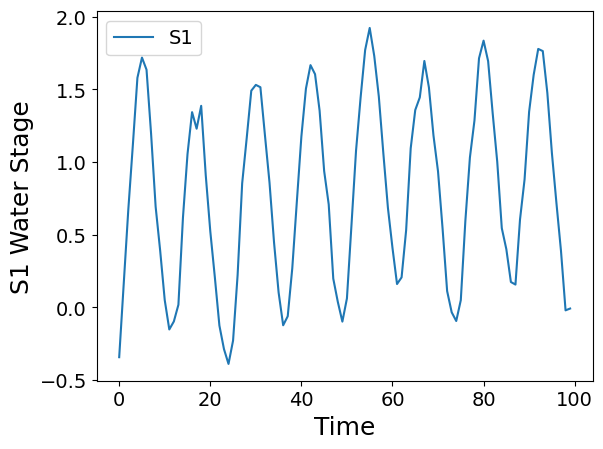

In [22]:
plt.plot(best_perf[:, 0], label='S1')
plt.xlabel('Time', fontsize=18)
plt.ylabel('S1 Water Stage', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [23]:
Optimal_gate = pd.DataFrame(best_gate.reshape(duration, -1) )
Optimal_gate.to_csv("GA_results/best_gate_event_low17.csv", index=False)
Optimal_gate

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,668,669,670,671
0,0.857653,0.453434,0.968702,0.876887,0.858022,0.447715,0.505905,0.280554,0.810419,0.104793,...,0.048412,0.130020,0.364131,0.377406,0.849111,0.320992,0.397024,0.286717,0.388968,0.995381
1,0.549321,0.903728,0.392527,0.826932,0.596805,0.381699,0.219913,0.413036,0.502088,0.139410,...,0.639348,0.058871,0.329352,0.780846,0.842462,0.962786,0.355741,0.582299,0.536060,0.644303
2,0.644415,0.805707,0.964184,0.343299,0.468506,0.208957,0.441745,0.272957,0.523587,0.124818,...,0.525722,0.998806,0.931970,0.832525,0.888180,0.920453,0.293951,0.954510,0.359947,0.224512
3,0.491238,0.953275,0.747218,0.609267,0.758230,0.803364,0.897431,0.918197,0.340493,0.317577,...,0.801517,0.510887,0.643424,0.788224,0.964909,0.577217,0.481784,0.861430,0.649301,0.106434
4,0.511999,0.012867,0.507798,0.040215,0.014566,0.716080,0.671596,0.003672,0.710652,0.391226,...,0.561157,0.628920,0.492584,0.778369,0.834953,0.073405,0.995234,0.045849,0.872378,0.743805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.465225,0.026226,0.844421,0.699586,0.042389,0.987403,0.620659,0.828785,0.362596,0.736388,...,0.212423,0.123578,0.900575,0.047164,0.226922,0.285134,0.312213,0.916762,0.829180,0.519230
96,0.406715,0.775790,0.091273,0.542396,0.055430,0.289267,0.341494,0.413828,0.818943,0.247796,...,0.528887,0.148659,0.015328,0.410507,0.206717,0.470991,0.486864,0.329144,0.377414,0.643460
97,0.245806,0.211363,0.581529,0.977448,0.496837,0.017620,0.979372,0.651278,0.154586,0.213937,...,0.030454,0.531636,0.773249,0.930482,0.486895,0.777593,0.130540,0.691356,0.643044,0.985551
98,0.930994,0.762684,0.319976,0.403475,0.465084,0.998466,0.351423,0.250293,0.673347,0.959718,...,0.968647,0.658476,0.145640,0.573216,0.178828,0.114732,0.639340,0.261110,0.119417,0.836802


In [24]:
Optimal_case = pd.DataFrame(best_perf)
Optimal_case.to_csv("GA_results/best_performance_event_low17.csv", index=False)
Optimal_case

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,-0.342455,-0.016708,-0.126339,-0.171759,0.007798,0.344984,0.073913,0.027961,0.740322,0.746408,...,0.552517,0.387653,-0.013680,0.123860,0.274166,0.108578,-0.167680,0.090636,0.066017,-0.017872
1,0.165782,0.386330,0.271779,0.289538,0.668410,0.866262,0.595089,0.781051,1.266517,1.266727,...,0.245480,0.140264,-0.078004,0.082846,0.297110,0.161063,-0.071607,0.156904,0.178983,0.179584
2,0.673157,0.811695,0.719002,0.862562,1.269267,1.136141,1.264659,1.489994,1.495071,1.669137,...,0.166802,-0.002450,-0.182621,-0.078959,0.049770,0.011422,-0.068166,0.127500,0.141269,0.132820
3,1.118219,1.160007,1.038891,1.175081,1.537360,1.639757,1.486319,1.689692,1.741118,1.822513,...,0.162217,0.054157,0.045790,0.202829,0.262353,0.188651,0.283660,0.480678,0.352735,0.484104
4,1.580021,1.608862,1.594349,1.751603,1.670452,1.849708,1.641160,1.836985,1.597021,1.540002,...,-0.142766,0.037203,0.280056,0.360635,0.191515,0.452266,0.696098,0.763152,0.511021,0.890333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.063086,1.256835,1.143692,1.074651,0.835669,1.116110,0.876453,0.930481,0.403860,0.700564,...,1.192667,1.473704,1.572233,1.774482,1.488554,1.712570,1.662796,1.547015,1.602084,1.779268
96,0.717338,1.006574,0.809411,0.831232,0.294048,0.310508,0.396744,0.445880,-0.028127,-0.060345,...,1.516621,1.774881,1.604002,1.773529,1.625204,1.742157,1.355800,1.491974,1.460093,1.571072
97,0.387965,0.726263,0.456778,0.390469,0.133899,0.137368,0.159423,0.051012,0.032277,0.035526,...,1.488137,1.655186,1.329884,1.745558,1.510061,1.516873,0.997530,1.306821,1.222462,1.196701
98,-0.020133,0.288496,0.065083,-0.057240,0.057950,0.050932,0.047559,0.029173,0.116450,0.081225,...,1.431124,1.565774,1.002371,1.023742,1.243839,1.288328,0.479732,0.744403,0.657084,0.615675


In [25]:
upper_threshold = 3.5
lower_threshold = 0

Optimal_case_reshape = Optimal_case.to_numpy().reshape((-1, 24, 4))

flood_threshold(Optimal_case_reshape, upper_threshold)
drought_threshold(Optimal_case_reshape, lower_threshold)


time steps: 0, areas: 0
time steps: 326, areas: 32.54594433333841


In [26]:
true_ws = saved_model.predict([test_cov[start_idx:end_idx], test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
true_ws = ws_scaler.inverse_transform(true_ws)

true_ws = true_ws.reshape((-1, 24, 4))
flood_threshold(true_ws, upper_threshold)
drought_threshold(true_ws, lower_threshold)

4/4 [==============================] - 0s 4ms/step
time steps: 0, areas: 0
time steps: 1512, areas: 340.3842472585093
